# Use pre-trained Conv-TasNet (Pytorch Audio) on MIR-1K dataset for vocal separation

- read audio files
- create paired vocals (without background) dataset
- load pre-trained model
- process audio to fit input req
- evaluate


In [1]:
# !pip install torchmetrics

In [1]:
import IPython.display as ipd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import itertools
import random
import numpy as np
import os
import torch
import torchaudio
from torchaudio.pipelines import CONVTASNET_BASE_LIBRI2MIX
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio, SignalDistortionRatio, PermutationInvariantTraining
from torchmetrics.functional.audio import scale_invariant_signal_noise_ratio, signal_distortion_ratio
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

# use GPU if available, otherwise, use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Train/Val/Test data

In [2]:
files = os.listdir('MIR-1K/MIR-1K/Wavfile')
num_files = len(files)

In [3]:
# Save artist names for reproducibility
# Note: artist 'tammy' has only one track

train_artists = ['khair',
 'heycat',
 'amy',
 'fdps',
 'Ani',
 'Kenshin',
 'bobon',
 'yifen',
 'davidson',
 'bug',
 'annar',
 'abjones',
 'geniusturtle',
 'stool',
 'tammy']

val_artists = ['titon', 'ariel']
test_artists = ['jmzen', 'leon']

In [4]:
def get_split_by_artist(artist_name, train, val, test):
    if artist_name in train:
        return 'train'
    elif artist_name in val:
        return 'val'
    elif artist_name in test:
        return 'test'

In [5]:
train_files = [file for file in files for artist in train_artists if artist in file]
val_files = [file for file in files for artist in val_artists if artist in file]
test_files = [file for file in files for artist in test_artists if artist in file]

### Generate pairs for all possible combinations
Note: pairs are unique without inverse pairs (i.e. (A, B) and (B, A) are considered the same pair and if (A, B) is present, (B, A) will not be listed as a separate pair.

In [6]:
train_pairs = [pair for pair in itertools.combinations(train_files,2) if pair[0].split('_')[0] != pair[1].split('_')[0]]
val_pairs = [pair for pair in itertools.combinations(val_files,2) if pair[0].split('_')[0] != pair[1].split('_')[0]]
test_pairs = [pair for pair in itertools.combinations(test_files,2) if pair[0].split('_')[0] != pair[1].split('_')[0]]

In [7]:
print(f"There are {len(train_pairs)} audio pairs in the training set.")
print(f"There are {len(val_pairs)} audio pairs in the validation set.")
print(f"There are {len(test_pairs)} audio pairs in the test set.")

There are 269004 audio pairs in the training set.
There are 1800 audio pairs in the validation set.
There are 5044 audio pairs in the test set.


## Evaluate pretrained Conv-TasNet on random sample of each set

### Define functions

In [8]:
def combine_vocals(vocals1, vocals2, sample_rate, save_as=None):
    """
    Combine 2 vocal audio waves.

    Saves mixed vocals to path `save_as`
    Returns mixed vocal wave.
    """
    if vocals1.shape[0] > vocals2.shape[0]:
        shorter, longer = vocals2, vocals1
    else:
        shorter, longer = vocals1, vocals2
    
    combined_len = shorter.shape[0]
    # resize longer vocals to match shape of shorter vocals
    longer_trimmed = longer[:combined_len]

    # mix both vocals
    mixed_tensor = torch.cat([longer_trimmed.reshape(1, combined_len), shorter.reshape(1, combined_len)])
    mixed = torch.mean(mixed_tensor, dim=0, keepdim=True)
    
    if save_as:
        torchaudio.save(f'{save_as}', mixed, sample_rate)
        
    return mixed, mixed_tensor
    

In [9]:
def load_vocals(file_pair, target_sr=8000):
    audio1, sample_rate = torchaudio.load(f"MIR-1K/MIR-1K/Wavfile/{file_pair[0]}")
    audio2, sample_rate = torchaudio.load(f"MIR-1K/MIR-1K/Wavfile/{file_pair[1]}")

    resample_8k = torchaudio.transforms.Resample(sample_rate, target_sr)
    vocals1 = resample_8k(audio1[1])
    vocals2 = resample_8k(audio2[1])
    return vocals1, vocals2
    

def load_and_mix_vocals(file_pairs, target_sr=8000, num_voices=2, sample_len=1):
    num_pairs = len(file_pairs)
    num_samples = sample_len*target_sr
    mixed_lst = []
    separated_lst = []
    
    for i, pair in tqdm(enumerate(file_pairs)):

        vocals1, vocals2 = load_vocals(pair, target_sr=target_sr)
    
        mixed, separated = combine_vocals(vocals1, vocals2, target_sr, 
                               # save_as=f"{paired_folder}/{mixed_name}"
                              )
        
        dim2 = mixed.shape[1]//num_samples
        # print(mixed.shape, separated.shape)
        mixed = torch.reshape(input=mixed[:, :dim2*num_samples], shape=(dim2, 1, num_samples))
        
        sep1 = separated[:, :dim2*num_samples][0].reshape(dim2, 1, num_samples)
        sep2 = separated[:, :dim2*num_samples][1].reshape(dim2, 1, num_samples)
        separated = torch.cat([sep1, sep2], dim=1)

        mixed_lst.append(mixed)
        separated_lst.append(separated)
        
    return torch.cat(mixed_lst), torch.cat(separated_lst)

In [22]:
def get_metrics(pred, target):
    """
    Calculate the Permutation-invariant SI-SNR and SDR for a given predicted split VS a target split.
    """
    sisnr_pit = PermutationInvariantTraining(scale_invariant_signal_noise_ratio,
                                   mode="speaker-wise", eval_func="max")
    sisnr_pit.cuda()
    sisnr = sisnr_pit(pred, target)

    sdr_pit = PermutationInvariantTraining(signal_distortion_ratio,
                                   mode="speaker-wise", eval_func="max")
    sdr_pit.cuda()
    sdr = sdr_pit(pred, target)
    
    return sisnr.item(), sdr.item()


def evaluate(model, X_test, y_test):
    """
    Evaluation wrapper function
    """

    pred = model(X_test)
    stacked = torch.cat([X_test, X_test], dim=1)
    # target = y_test.reshape(1, 2, -1) 
    sisnr, sdr = get_metrics(pred, y_test)
    sisnr_orig, sdr_orig = get_metrics(stacked, y_test)
    sisnri = sisnr - sisnr_orig
    sdri = sdr - sdr_orig
    return sisnri, sdri

In [11]:
def evaluate_data_loader(model, data_loader):
    sisnris = []
    sdris = []
    with torch.no_grad():
        for batch_inputs, batch_labels in tqdm(test_dl):
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            # print(batch_inputs.shape)
            # print(batch_labels.shape)
    # random.seed(47)
    # print(random.sample(test_pairs, 12))
    # with torch.no_grad():
            # for pair in random.sample(test_pairs, 12):
                # model = CONVTASNET_BASE_LIBRI2MIX.get_model()
                # model = model.to(device)
                # print(f"Initialized CONVTASNET_BASE_LIBRI2MIX model.")
                # mixed, sep = load_and_mix_vocals([pair], target_sr=8000, num_voices=2, sample_len=sample_len)
                # batch_inputs, batch_labels = mixed.to(device), sep.to(device)
            sisnri, sdri = evaluate(model, batch_inputs, batch_labels)
            # sisnr = sisnr.detach().cpu()
            # sdr = sdr.detach().cpu()
            # print(sisnr, sdr)
            del batch_inputs
            del batch_labels
            torch.cuda.empty_cache()
            sisnris.append(sisnri)
            sdris.append(sdri)

    print(f"Average SI-SNRi: {np.mean(sisnris)}dB")
    print(f"Average SDRi: {np.mean(sdris)}dB")

    return sisnris, sdris

### Evaluation loop

In [10]:
random.seed(47)
sample_len=3
sample_size = 500
batch_size = 2

In [12]:
metrics = {'sisnri': [],
          'sdri': []}
for pairs in [train_pairs, val_pairs, test_pairs]:

    mixed, sep = load_and_mix_vocals(random.sample(pairs, sample_size), target_sr=8000, num_voices=2, sample_len=sample_len)
    
    print(f"There are {len(mixed)} mixed samples of length {sample_len}s in the evaluation set.")
    
    test_dl = DataLoader(TensorDataset(mixed, sep), batch_size=batch_size, shuffle=True)
    print(f"Loaded DataLoader with batch size {batch_size}.")
    
    model = CONVTASNET_BASE_LIBRI2MIX.get_model()
    model = model.to(device)
    print(f"Initialized CONVTASNET_BASE_LIBRI2MIX model.")
    
    sisnris, sdris = evaluate_data_loader(model, test_dl)
    metrics['sisnri'].append(sisnris)
    metrics['sdri'].append(sdris)

    del model
    torch.cuda.empty_cache()

500it [05:44,  1.45it/s]


There are 948 mixed samples of length 3s in the evaluation set.
Loaded DataLoader with batch size 2.
Initialized CONVTASNET_BASE_LIBRI2MIX model.


  0%|          | 0/474 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 474/474 [07:15<00:00,  1.09it/s]


Average SI-SNRi: 14.078300256242795dB
Average SDRi: 14.345106704561394dB


500it [05:10,  1.61it/s]


There are 1042 mixed samples of length 3s in the evaluation set.
Loaded DataLoader with batch size 2.
Initialized CONVTASNET_BASE_LIBRI2MIX model.


100%|██████████| 521/521 [06:40<00:00,  1.30it/s]


Average SI-SNRi: 3.6739185766778144dB
Average SDRi: 4.99103882136592dB


500it [03:56,  2.11it/s]


There are 1031 mixed samples of length 3s in the evaluation set.
Loaded DataLoader with batch size 2.
Initialized CONVTASNET_BASE_LIBRI2MIX model.


100%|██████████| 516/516 [05:39<00:00,  1.52it/s]

Average SI-SNRi: 10.90413087994481dB
Average SDRi: 11.782592025354447dB


### Process metrics for visualization

In [43]:
df = pd.DataFrame(metrics)
sisnri_df = pd.DataFrame(df['sisnri'].tolist()).T
sdri_df = pd.DataFrame(df['sdri'].tolist()).T

In [44]:
sisnri_df.columns = ["train", "val", "test"]
sdri_df.columns = ["train", "val", "test"]

In [72]:
sisnri_df.mean().rename("SI-SNRi").to_frame().join(sdri_df.mean().rename("SDRi").to_frame())

,SI-SNRi,SDRi
train,14.078300,14.345107
val,3.673919,4.991039
test,10.904131,11.782592


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/tmp/ipykernel_2734/2287603906.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sisnri_df['train'], label='train')
/tmp/ipykernel_2734/2287603906.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sisnri_df['val'], label='val')
/tmp/ipykernel_2734/2287603906.py:3: UserWarning: 

`distplot` i

Text(0.5, 1.0, 'SI-SNRi')

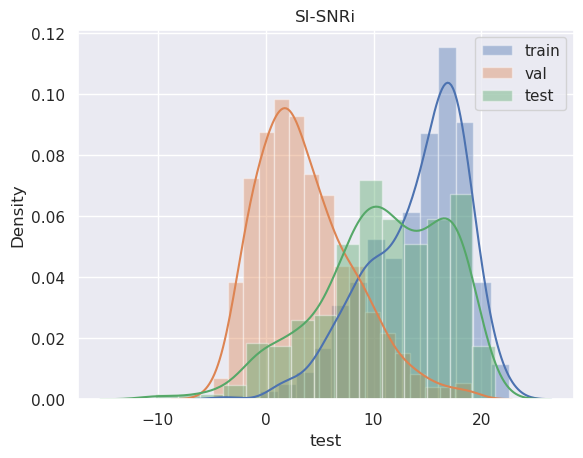

In [59]:
sns.distplot(sisnri_df['train'], label='train')
sns.distplot(sisnri_df['val'], label='val')
sns.distplot(sisnri_df['test'], label='test')
plt.legend()
plt.title("SI-SNRi")

/tmp/ipykernel_2734/2061499927.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sdri_df['train'], label='train')
/tmp/ipykernel_2734/2061499927.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sdri_df['val'], label='val')
/tmp/ipykernel_2734/2061499927.py:3: UserWarning: 

`distplot` is a 

Text(0.5, 1.0, 'SDRi')

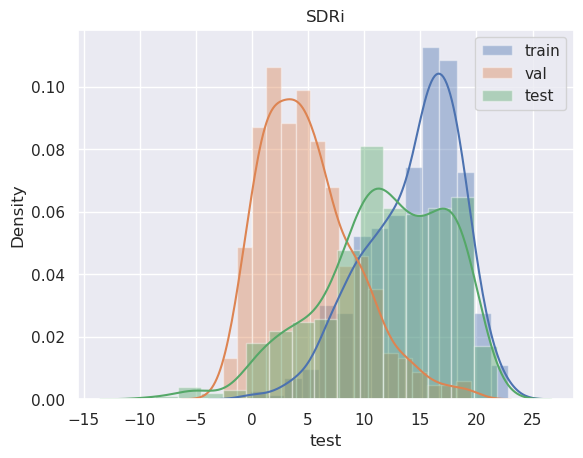

In [60]:
sns.distplot(sdri_df['train'], label='train')
sns.distplot(sdri_df['val'], label='val')
sns.distplot(sdri_df['test'], label='test')
plt.legend()
plt.title("SDRi")

### Investigate validation set by looking at examples

In [11]:
mixed, sep = load_and_mix_vocals(random.sample(val_pairs, sample_size)[:5], target_sr=8000, num_voices=2, sample_len=sample_len)
print(f"There are {len(mixed)} mixed samples of length {sample_len}s in the evaluation set.")
    
test_dl = DataLoader(TensorDataset(mixed, sep), batch_size=batch_size, shuffle=True)
print(f"Loaded DataLoader with batch size {batch_size}.")

model = CONVTASNET_BASE_LIBRI2MIX.get_model()
model = model.to(device)
print(f"Initialized CONVTASNET_BASE_LIBRI2MIX model.")
# del model
# torch.cuda.empty_cache()

5it [00:07,  1.47s/it]


There are 11 mixed samples of length 3s in the evaluation set.
Loaded DataLoader with batch size 2.
Initialized CONVTASNET_BASE_LIBRI2MIX model.


In [12]:
mixed.shape

torch.Size([11, 1, 24000])

In [13]:
with torch.no_grad():
    pred = model(mixed.to(device))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


In [15]:
pred.shape

torch.Size([11, 2, 24000])

In [16]:
sep.shape

torch.Size([11, 2, 24000])

In [17]:
ipd.Audio(pred[:1, 0].cpu().detach().numpy(), rate=8000)

In [18]:
ipd.Audio(pred[:1, 1].cpu().detach().numpy(), rate=8000)

In [19]:
ipd.Audio(sep[:1, 1].cpu().detach().numpy(), rate=8000)

In [20]:
ipd.Audio(sep[:1, 0].cpu().detach().numpy(), rate=8000)

In [21]:
ipd.Audio(mixed[0].cpu().detach().numpy(), rate=8000)

In [30]:
mixed[:1].shape

torch.Size([1, 1, 24000])

In [33]:
sep = sep.to(device)
stacked = torch.cat([mixed[:1], mixed[:1]], dim=1).to(device)
sisnr, sdr = get_metrics(pred[:1], sep[:1])
sisnr_orig, sdr_orig = get_metrics(stacked, sep[:1])

In [34]:
sisnr

-2.0978779792785645

In [35]:
sisnr_orig

0.11902225017547607

In [36]:
sdr

-0.9643821716308594

In [37]:
sdr_orig

0.2260040044784546

## Test on LWQ Vocals

In [13]:
audio, sample_rate = torchaudio.load(f"gbqq_lwq_mixed.wav")
resample_8k = torchaudio.transforms.Resample(sample_rate, 8000)
vocals = resample_8k(audio)
mixed = torch.mean(vocals, dim=0, keepdim=True)

In [14]:
ipd.Audio(mixed.detach().numpy(), rate=8000)

In [20]:
mixed[:, :10000]

tensor([[-0.0003, -0.0007, -0.0005,  ..., -0.1072, -0.1265, -0.1351]])

In [24]:
est_lwq = model(mixed[:, :20000].reshape(1, 1, -1))

In [25]:
ipd.Audio(est_lwq[:, 0].detach().numpy(), rate=8000)

In [26]:
ipd.Audio(est_lwq[:, 1].detach().numpy(), rate=8000)